In [32]:
# Imports

import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sktime.classification.shapelet_based import MrSEQLClassifier
from sktime.transformations.panel.rocket import MiniRocket
from sktime.datatypes._panel._convert import from_2d_array_to_nested
from sktime.transformations.panel.rocket import Rocket

warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", 100)

In [33]:
# Opening up file containing GWAS data and reading in

file = open("Second_GWAS/Second_GWAS_Add.raw", "r")
lines = file.readlines()
len(lines)

110

In [34]:
# Loading GWAS data into DF in the correct format

columns = lines[0].strip("\n").split(" ")
columns = [n.split("_", 1)[0] for n in columns]

df = pd.DataFrame(columns=columns)
data = []

for line in lines[1:]:
    newRow = line.strip("\n").split(" ")
    for position in range(0, len(newRow)):
        if newRow[position] == "0":
            newRow[position] = "2"
        elif newRow[position] == "2":
            newRow[position] = "0"
        
    data.append(newRow)

df = pd.DataFrame(data, columns=columns)

In [35]:
# Checking to see split between cases and controls

df["PHENOTYPE"].value_counts()

1    55
0    54
Name: PHENOTYPE, dtype: int64

In [36]:
# Printing shape of df

df.shape

(109, 41313)

In [37]:
# Printing shape of df

df.columns

Index(['FID', 'IID', 'PAT', 'MAT', 'SEX', 'PHENOTYPE', 'rs7433861',
       'rs1166974', 'rs1166975', 'rs10446372',
       ...
       'rs4030335', 'rs7374010', 'rs9877345', 'rs7373662', 'rs12630742',
       'rs11916265', 'rs7374354', 'rs9325418', 'rs9325420', 'rs10154902'],
      dtype='object', length=41313)

In [38]:
df["PHENOTYPE"] = df["PHENOTYPE"].replace("0","case")
df["PHENOTYPE"] = df["PHENOTYPE"].replace("1","control")

In [39]:
# Dropping columns and seperating phenotype column
phenotype = df.pop("PHENOTYPE")
dfTest = df.drop(columns=["FID","IID","PAT","MAT","SEX"])

In [40]:
# Replacing missing values in df with most common allele for 

imp = SimpleImputer(missing_values="NA", strategy="most_frequent")
idf = pd.DataFrame(imp.fit_transform(dfTest))
idf.columns = dfTest.columns

In [41]:
# Converting columns to be numberical

dfTest = idf.apply(pd.to_numeric)

'case'

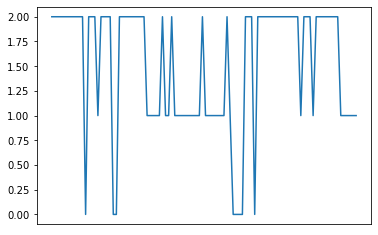

In [42]:
# Visualising first 100 SNPs of first case

dfTranspose = dfTest.T
plt.xticks([])
plt.plot(dfTranspose[0][0:100], color="tab:blue")
phenotype[0]

In [43]:
# Splitting data into training data and testing data

xTrain, xTtest, yTrain, yTest = train_test_split(dfTest, phenotype, train_size=0.7)

In [44]:
# Classifying GWAS data using RandomForest

results = []
for n in range(0,10):
    xTrain, xTtest, yTrain, yTest = train_test_split(dfTest, phenotype, train_size=0.7)
    
    rfc = RandomForestClassifier()
    rfc.fit(xTrain, yTrain)
    
    yPredicted = rfc.predict(xTtest)
    results.append(accuracy_score(yTest, yPredicted))
    
print(f"Average accuracy for RandomForest on entire dataset: {sum(results) / len(results)}")

Average accuracy for RandomForest on entire dataset: 0.5272727272727273


In [45]:
# Converting df to array structure

dfTestSeries = from_2d_array_to_nested(dfTest)

In [46]:
# Splitting time series data into training data and testing data

#xTrain, xTest, yTrain, yTest = train_test_split(dfTestSeries, phenotype, train_size=0.7, random_state=1)

In [47]:
# Extracting values from training split

#yTrain = yTrain.values
#yTest = yTest.values

#xTrain = xTrain.reset_index()
#xTrain = xTrain.drop(columns=["index"])

#xTest = xTest.reset_index()
#xTest = xTest.drop(columns=["index"])

In [48]:
# Classifying GWAS data using MiniRocket

results = []
for n in range(0,10):
    xTrain, xTest, yTrain, yTest = train_test_split(dfTestSeries, phenotype, train_size=0.7)
    minirocket = MiniRocket()
    minirocket.fit(xTrain)
    xTrainTransform = minirocket.transform(xTrain)

    classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
    classifier.fit(xTrainTransform, yTrain)

    xTestTransform = minirocket.transform(xTest)
    yPredict = classifier.predict(xTestTransform)

    results.append(accuracy_score(yTest, yPredict))
    
print(f"Average accuracy for MiniRocket on entire dataset: {sum(results) / len(results)}")

Average accuracy for MiniRocket on entire dataset: 0.4666666666666666


In [49]:
# Classifying GWAS data using MrSEQL

#ms = MrSEQLClassifier(seql_mode="fs")

#ms.fit(xTrain, yTrain)
#yPredict = ms.predict(xTest)

#print("Accuracy with MrSEQL: %2.3f" % metrics.accuracy_score(yTest, yPredict))
#print(confusion_matrix(yTest, yPredict))
#print(classification_report(yTest, yPredict))

In [63]:
results = []
for k in range(1,2):
    
    print(f"Run {k}")
    
    validationScores = []
    testScores = []
    xTrain, xTest, yTrain, yTest = train_test_split(dfTest, phenotype, train_size=0.7)
    xTrainSplit, xValidate, yTrainSplit, yValidate = train_test_split(xTrain, yTrain, train_size=0.7)

    for n in range(0,413):
        
        if(n%41 == 0):
            print(f"Progress: {(n/41) * 10}")
            
        windowStart = n * 100
        windowEnd = windowStart + 100 # size 100 instead of 99 for .iloc

        xTrainWindow = xTrainSplit.iloc[:,windowStart:windowEnd]
        xValidateWindow = xValidate.iloc[:,windowStart:windowEnd]

        xTrainWindowSeries = from_2d_array_to_nested(xTrainWindow)
        xValidateWindowSeries = from_2d_array_to_nested(xValidateWindow)

        minirocket = MiniRocket()
        minirocket.fit(xTrainWindowSeries)
        xTrainTransform = minirocket.transform(xTrainWindowSeries)

        classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
        classifier.fit(xTrainTransform, yTrainSplit)

        xValidateTransform = minirocket.transform(xValidateWindowSeries)
        score = classifier.score(xValidateTransform, yValidate)
        validationScores.append(score)
        
    windowsAboveThreshold = [n for n in range(len(validationScores)) if validationScores[n] > 0.5]
    print(f"Window positions from validation with accuracy above threshold for run {k}")
    print(windowsAboveThreshold)
    
    windowsAboveThresholdAfterTest = []
    
    for n in windowsAboveThreshold:
        
        windowStart = n * 100
        windowEnd = windowStart + 100

        xTrainWindow = xTrain.iloc[:,windowStart:windowEnd]
        xTestWindow = xTest.iloc[:,windowStart:windowEnd]

        xTrainWindowSeries = from_2d_array_to_nested(xTrainWindow)
        xTestWindowSeries = from_2d_array_to_nested(xTestWindow)

        minirocket = MiniRocket()
        minirocket.fit(xTrainWindowSeries)
        xTrainTransform = minirocket.transform(xTrainWindowSeries)

        classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
        classifier.fit(xTrainTransform, yTrain)

        xTestTransform = minirocket.transform(xTestWindowSeries)
        score = classifier.score(xTestTransform, yTest)
        testScores.append(score)
    
    windowsAboveThresholdAfterTest = [windowsAboveThreshold[n] for n in range(len(windowsAboveThreshold)) if testScores[n] > 0.5]
    print(f"Window positions from validation with accuracy above threshold for run {k}")
    print(windowsAboveThresholdAfterTest)
    
    results.append(windowsAboveThresholdAfterTest)

Run 1
Progress: 0.0
Progress: 10.0
Progress: 20.0
Progress: 30.0
Progress: 40.0
Progress: 50.0
Progress: 60.0
Progress: 70.0
Progress: 80.0
Progress: 90.0
Progress: 100.0
Window positions from validation with accuracy above threshold for run 1
[10, 11, 17, 25, 53, 82, 100, 112, 114, 116, 141, 172, 179, 180, 192, 203, 209, 234, 235, 255, 282, 298, 310, 322, 334, 347, 366, 369, 406]
Window positions from validation with accuracy above threshold for run 1
[10, 17, 82, 116, 179, 192, 255, 310, 322, 366, 369]


In [57]:
resultSet = map(set, results[1:])
validatiedCommonResults = set.intersection(*resultSet)

TypeError: 'numpy.float64' object is not iterable

In [58]:
validatiedCommonResults

set()

In [53]:
# Selecting those areas

#xTrainSplit = xTrain.iloc[:, np.r_[16200:16300,32900:33000,39900,40000]]
#xtestSplit = xTest.iloc[:, np.r_[16200:16300,32900:33000,39900,40000]]

#xTrainSplit = xTrain.iloc[:, 32100:32200]
#xtestSplit = xTest.iloc[:, 32100:32200]
#xTrainSplit

In [65]:
results = []
for n in range(0,10):
    xTrain, xTest, yTrain, yTest = train_test_split(dfTest, phenotype, train_size=0.7)
    
    xTrain = xTrain.iloc[:, 32200:32300]
    xTest = xTest.iloc[:, 32200:32300]
    
    xTrain = from_2d_array_to_nested(xTrain)
    xTest = from_2d_array_to_nested(xTest)
    minirocket = MiniRocket()
    minirocket.fit(xTrain)
    xTrainTransform = minirocket.transform(xTrain)

    classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
    classifier.fit(xTrainTransform, yTrain)

    xTestTransform = minirocket.transform(xTest)
    yPredict = classifier.predict(xTestTransform)

    results.append(accuracy_score(yTest, yPredict))
    
print(f"Average accuracy for MiniRocket on entire dataset: {sum(results) / len(results)}")

Average accuracy for MiniRocket on entire dataset: 0.5212121212121212


In [55]:
xTrainWindowSeries

,0
0,0 1 1 2 2 1 3 1 4 1 5 ...
1,0 0 1 1 2 2 3 2 4 2 5 ...
2,0 2 1 2 2 2 3 2 4 2 5 ...
3,0 1 1 1 2 2 3 2 4 2 5 ...
4,0 2 1 1 2 1 3 2 4 1 5 ...
5,0 2 1 2 2 2 3 2 4 2 5 ...
6,0 2 1 2 2 2 3 2 4 2 5 ...
7,0 2 1 2 2 2 3 2 4 1 5 ...
8,0 1 1 1 2 1 3 2 4 1 5 ...
9,0 2 1 2 2 1 3 1 4 2 5 ...
